# Markov Chain Monte Carlo Sampling (Metropolis-Hastings and MALA)

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)


## Question 3: Markov Chain Monte Carlo

- Apply the simple random-walk Metropolis-Hasting and Metropolis Adjusted Langevin Algorithm (MALA)
to an unnormalized distribution.
- Provide the histogram of the samples and the trace plot of the samples to see how the chain moved
around.
- Compare the performance of these approaches.

References:

- https://www.aptech.com/resources/tutorials/bayesian-fundamentals/metropolis-hastings-sampler/
- https://stephens999.github.io/fiveMinuteStats/MH_intro.html
- https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisAdjustedLangevinAlgorithm
- https://www.youtube.com/watch?v=yCv2N7wGDCw


### Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
models_dir = "./drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

### Imports and Datasets

In [ ]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torch.distributions.multivariate_normal import MultivariateNormal

import normflows as nf

import copy

%matplotlib inline

### Unnormalized Distribution:

$$
p(\mathbf{x}) = \exp({-\sum_{i} x_{i}^4} - 0.5 \sum_{i\neq{j}}x_{i}^2 x_{j}^2)
$$

In [ ]:
# Define the distribution
# ------------------------------------------
def p(x: np.array) -> float:
    "Target distribution"
    xi2 = x**2
    xi4 = xi2**2
    sum_xi4 = np.sum(xi4)
    return np.exp((-1)*sum_xi4 - (0.5)*(np.sum(xi2 @ np.transpose(xi2))-sum_xi4))

### Simple Random-Walk Metropolis-Hastings Algorithm


In [ ]:
# Random-walk Metropolis-Hasting algorithm
# ------------------------------------------
def sample_q(x: np.array) -> np.array:
    """Proposal distribution is Gaussian(x, I)"""
    return np.random.multivariate_normal(x, np.eye(len(x)))

n_dim = 2
n_iters = 100000
burn_in = 10000
x0 = np.ones(n_dim)*0.01

samples = []
for i in range(n_iters + burn_in):
    u = np.random.uniform(0, 1)
    x_star = sample_q(x0)
    p_xstar = p(x_star)
    p_x0 = p(x0)
    if u < min(1, (p_xstar / p_x0)):
        x0 = x_star
        if i > burn_in:
            samples.append(x_star)
    if i % 10000 == 0:
        print(f'Iter {i}/{n_iters + burn_in}')

Iter 0/110000
Iter 10000/110000
Iter 20000/110000
Iter 30000/110000
Iter 40000/110000
Iter 50000/110000
Iter 60000/110000
Iter 70000/110000
Iter 80000/110000
Iter 90000/110000
Iter 100000/110000


In [ ]:
# Report effective sample size
print(f'Random-walk MH effective sample size: {len(samples)}/{n_iters}')

Random-walk MH effective sample size: 36882/100000


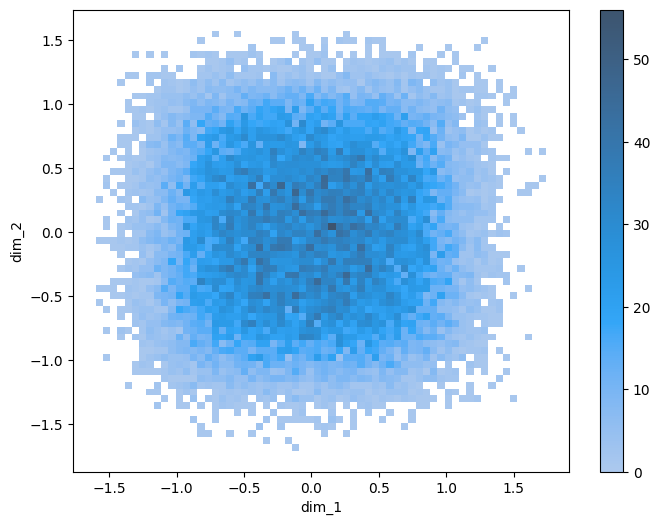

In [ ]:
# Plot histogram
df = pd.DataFrame(samples, columns=[f'dim_{i+1}' for i in range(n_dim)])
fig, ax = plt.subplots(1, 1, figsize=(8,6))
if n_dim > 1:
    sns.histplot(df, x="dim_1", y="dim_2", cbar=True, ax=ax);
else:
    sns.histplot(df, x="dim_1", cbar=True, ax=ax);

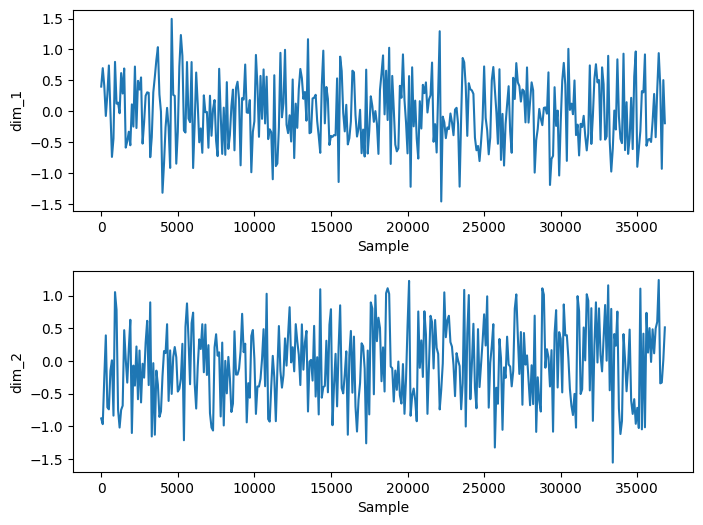

In [ ]:
# Create trace plot
fig, ax = plt.subplots(n_dim, 1, figsize=(8,6))
for i in range(n_dim):
    sns.lineplot(x=df.index[::100], y=df.iloc[:, i][::100], ax=ax[i])
    ax[i].set_xlabel("Sample")
fig.subplots_adjust(hspace=0.3)

### Metropolis-Adjusted Langevin Algorithm (MALA)

Since
$$
\ln{p(\mathbf{x})} = {-\sum_{i} x_{i}^4} - 0.5 \sum_{i\neq{j}}x_{i}^2 x_{j}^2
$$
we have
$$
\nabla{\ln{p(\mathbf{x})}} =
\begin{bmatrix}
-4x_{1}^3 - 0.5(4x_{1}*\sum_{j\neq{1}} x_{j}^2)
\\ \vdots
\\ -4x_{d}^3 - 0.5(4x_{d}*\sum_{j\neq{d}} x_{j}^2)
\end{bmatrix}
$$ where $d = dim(\mathbf{x})$.

In [ ]:
# MALA algorithm
# ------------------------------------------
def calc_grad_ln_px(x: np.array) -> np.array:
    """Returns vector of partial derivatives for ln(p(x))."""
    grad = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        sum_xj_sq = np.sum(x**2) - x[i]**2
        grad[i] = (-4) * (x[i]**3) - (2) * x[i] * sum_xj_sq
    return grad

n_dim = 2
n_iters = 100000
burn_in = 10000
x0 = np.ones(n_dim)*0.01
eps = 0.5
zero_vec = np.zeros(n_dim)
cov_mat = eps * np.eye(n_dim)

samples = []
for i in range(n_iters + burn_in):
    u = np.random.uniform(0, 1)
    grad_x0 = calc_grad_ln_px(x0)
    gaus_noise = np.random.multivariate_normal(zero_vec, cov_mat)
    assert grad_x0.shape == x0.shape
    assert gaus_noise.shape == x0.shape

    x_tilde = x0 + (eps/2) * grad_x0 + gaus_noise
    grad_x_tilde = calc_grad_ln_px(x_tilde)

    p_x_tilde = p(x_tilde)
    p_x0 = p(x0)
    q_x_tilde = np.exp(
        (-1) *
        np.linalg.norm((p_x_tilde - p_x0 - (eps/2) * grad_x0) / (2*eps)) ** 2
    )
    q_x0 = np.exp(
        (-1) *
        np.linalg.norm((p_x0 - p_x_tilde - (eps/2) * grad_x_tilde) / (2*eps)) ** 2
    )

    if u < min(1, ((p_x_tilde/p_x0) * (q_x0/q_x_tilde))):
        x0 = x_tilde
        if i > burn_in:
            samples.append(x_tilde)
    if i % 10000 == 0:
        print(f'Iter {i}/{n_iters + burn_in}')


Iter 0/110000
Iter 10000/110000
Iter 20000/110000
Iter 30000/110000
Iter 40000/110000
Iter 50000/110000
Iter 60000/110000
Iter 70000/110000
Iter 80000/110000
Iter 90000/110000
Iter 100000/110000


In [ ]:
# Report effective sample size
print(f'MALA effective sample size: {len(samples)}/{n_iters}')

MALA effective sample size: 54777/100000


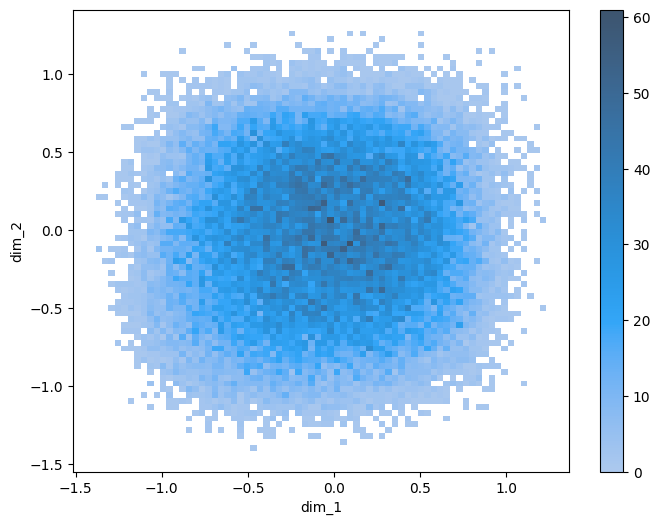

In [ ]:
# Plot histogram
df = pd.DataFrame(samples, columns=[f'dim_{i+1}' for i in range(n_dim)])
fig, ax = plt.subplots(1, 1, figsize=(8,6))
if n_dim > 1:
    sns.histplot(df, x="dim_1", y="dim_2", cbar=True, ax=ax);
else:
    sns.histplot(df, x="dim_1", cbar=True, ax=ax);

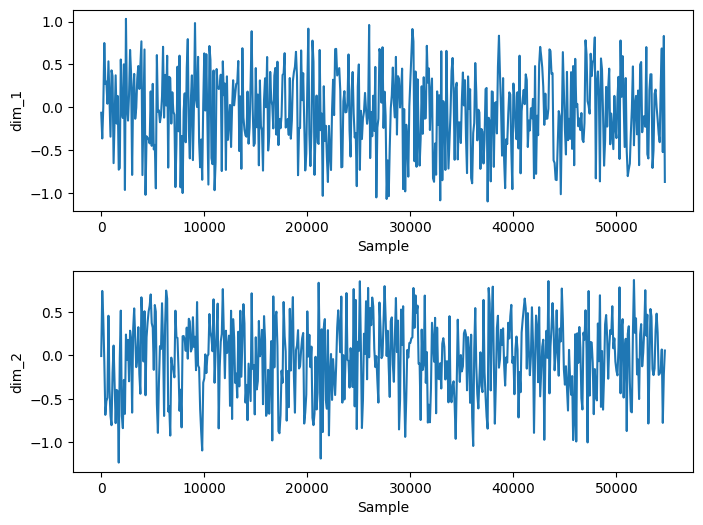

In [ ]:
# Create trace plot
fig, ax = plt.subplots(n_dim, 1, figsize=(8,6))
for i in range(n_dim):
    sns.lineplot(x=df.index[::100], y=df.iloc[:, i][::100], ax=ax[i])
    ax[i].set_xlabel("Sample")
fig.subplots_adjust(hspace=0.3)

### Performance Comparison

The effective sample size for MALA is much higher than the effective sample size for the random-walk MH algorithm (54,777/100,000 vs 36,882/100,000, resp.),
indicating that MALA is more computationally efficient (i.e., the acceptance
rate is higher meaning that for a fixed number of iterations, a larger share of those iterations are accepted as valid samples from the target distribution).